In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 01. Introduction to the dataset and the objectives of the exercise

**Dataset Name:** Credit Card Fraud Detection

**Dataset Source:** [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)  

**Dataset Description:**  
This dataset contains information about transactions made by credit cards in September 2013 by European cardholders. Almost all of the variables are the result of a PCA transformation, with no prior background information available due to the confidentiality of the data.

**Objective of the exercise:** The goal is to recognize fraudulent credit card transactions so that customers are not charged for items they did not purchase.


In [ ]:
credit_df = pd.read_csv("creditcard.csv")
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Note:** As mentioned in the dataset description, almost all of the variables were created using a PCA transformation. This means that variables *V1–V28* are uncorrelated with each other, and each represents a combination of correlated variables from the original dataset.  

Because the data is confidential, sadly we do not know the original meaning of most variables, but it does not stop us from building prediction models. There are only two named features:

- **Time** – the time elapsed between this transaction and the first recorded transaction  
- **Amount** – the monetary value of the transaction  

Additionally, the dataset contains the **Class** variable, where:  
- **0** – means no fraud detected  
- **1** – means fraud was detected

In [ ]:
credit_df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

**Note:** All of the variables are numerical.

In [ ]:
fraud_count = credit_df["Class"].value_counts()
fraud_count = fraud_count.rename({0: "No Fraud", 1: "Fraud"})
print(fraud_count)

Class
No Fraud    284315
Fraud          492
Name: count, dtype: int64


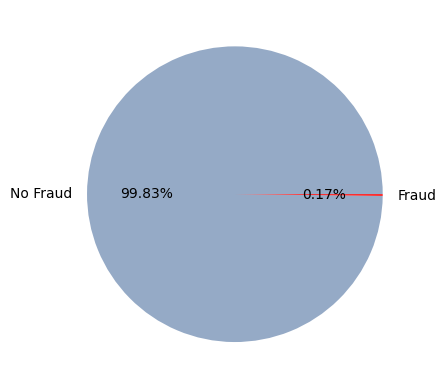

In [ ]:
plt.pie(fraud_count, labels=fraud_count.index, autopct="%1.2f%%", colors=["#95AAC6", "#ff0000"])
plt.show()

**Note:** As we can see, this dataset is extremely unbalanced — only around 0.17% of the data represents fraud, while the remaining 99.83% does not. This reflects a very realistic scenario, but it also means we need to properly address the imbalance. Otherwise, our models might fail to recognize meaningful fraud patterns and become biased due to the huge difference in class representation.

In [ ]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Note:**  As all variables are numerical, we can use the `describe()` function on the whole dataset. From the summary statistics, we can gain a few insights.  

All PCA-generated features (*V1–V28*) ranges vary quite a lot, but this is expected since PCA components can take both positive and negative values. However, we cannot do much storytelling because we do not have information about the original data.  

We can, however, take a closer look at the `Time` and `Amount` features: The `Time` variable spans from 0 seconds to almost 2 days. The `Amount` feature is highly concentrated around lower values (mean ≈ 88), but there are some transactions reaching over 25,000.


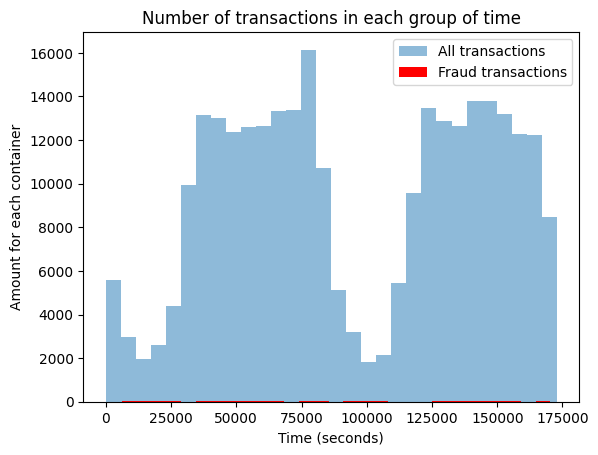

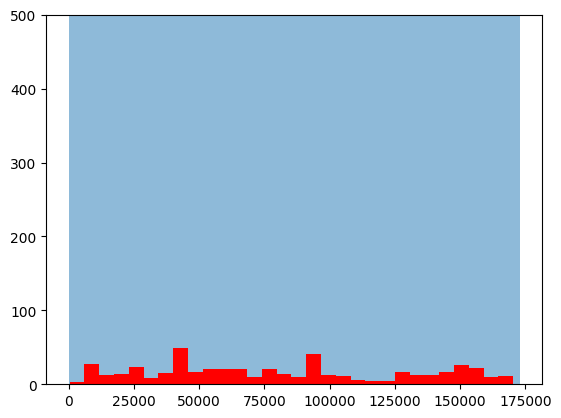

In [ ]:
plt.hist(credit_df["Time"], alpha=0.5, bins=30, label="All transactions")
plt.hist(credit_df[credit_df["Class"] == 1]["Time"], color="red", bins=30, label="Fraud transactions")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount for each container")
plt.title("Number of transactions in each group of time")
plt.legend()
plt.show()

plt.hist(credit_df["Time"], alpha=0.5, bins=30)
plt.hist(credit_df[credit_df["Class"] == 1]["Time"], color="red", bins=30)
plt.ylim(0, 500)
plt.show()

**Note:** Because of the imbalance, the plot may be a bit hard to read. However, after zooming in on the lower parts, we can see that fraudulent transactions appear throughout the entire timeline. This indicates that fraud is not concentrated in any specific time window.

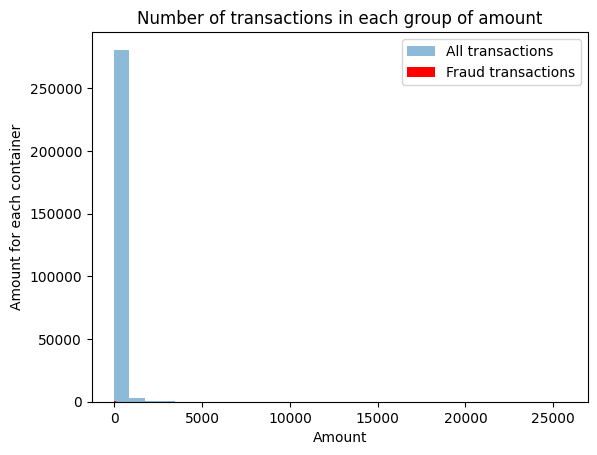

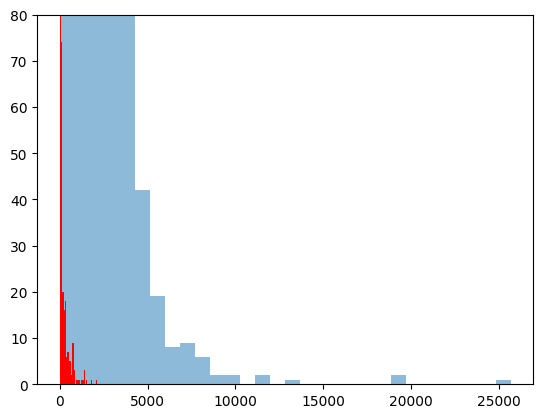

In [ ]:
plt.hist(credit_df["Amount"], alpha=0.5, bins=30, label="All transactions")
plt.hist(credit_df[credit_df['Class'] ==1]["Amount"], bins=30, label="Fraud transactions", color="red")
plt.xlabel("Amount")
plt.ylabel("Amount for each container")
plt.title("Number of transactions in each group of amount")
plt.legend()
plt.show()

plt.hist(credit_df["Amount"], alpha=0.5, bins=30)
plt.hist(credit_df[credit_df['Class'] ==1]["Amount"], bins=30, color="red")
plt.ylim(0, 80)
plt.show()

**Note:** Here, however, we can see that fraudulent transactions mostly occur at lower amounts — especially between 0 and around 2,500 dollars—and are mostly concentrated at the beginning of the scale.

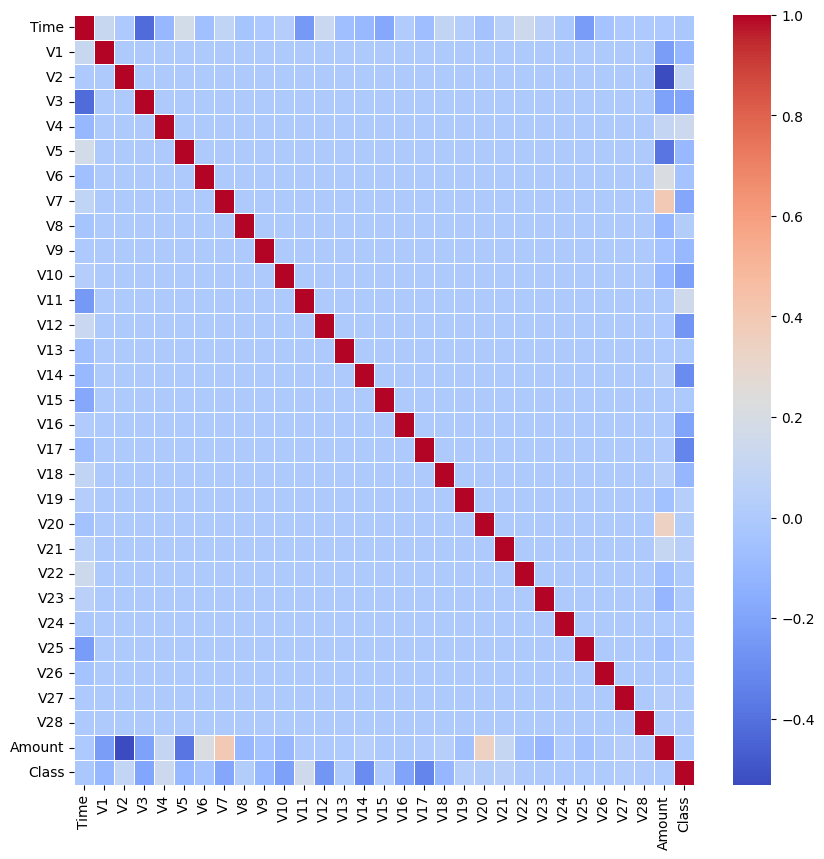

In [ ]:
plt.figure(figsize=(10, 10))
credit_corr_matrix = credit_df.corr()
sns.heatmap(credit_corr_matrix, annot=False, linewidths=0.5, cmap="coolwarm")
plt.show()

**Note:** As we can see, the PCA transformation was applied correctly — *V1–V28* show almost no mutual correlation, and the remaining correlations appear only with `Class` or `Amount` variables.

In [ ]:
print(f"Dataset size before dropping empty rows: {credit_df.shape[0]}")
credit_df = credit_df.dropna()
print(f"Dataset size after dropping empty rows: {credit_df.shape[0]}")

Dataset size before dropping empty rows: 284807
Dataset size after dropping empty rows: 284807


**Note:** To make sure that the dataset contained no missing values, I applied the `dropna()` function, however since the dataset size did not change, the data was already cleaned.

# 02. Training Classification Models

The goal is to create a classification model that can identify transactions as fraud or non-fraud. I decided to try four different model types:

- **Logistic Regression** – a linear model that predicts the probability of fraud based on feature weights.
- **Decision Tree** – a non-linear model that splits the data into regions based on feature thresholds. It can capture complex patterns but may overfit.
- **Random Forest Classifier** – an ensemble of many decision trees, which reduces overfitting and improves generalization.
- **XGB Classifier** – also tree-based, but each new tree is built to correct errors made by the previous ones (*boosting*), making it very powerful.

I will evaluate all models using **StratifiedKFold cross-validation**, which preserves the imbalance ratio in every fold so that both fraud and non-fraud samples are properly represented.

For final evaluation metrics, I  will use:

- **Precision** – how many predicted frauds were actually frauds  
- **Recall** – how many actual frauds were correctly identified  
- **F1-score** – a balance between precision and recall  

These metrics are the most appropriate for imbalanced datasets.

To handle class imbalance, I will apply methods like:

- **class_weight="balanced"** – it increases the weight of the minority class.
- **Stratified split** – preserves the fraud/non-fraud ratio in both training and test sets.
- **SMOTE** – oversamples the minority class by creating synthetic samples through interpolation in training dataset.

Additionally, I will test different **decision thresholds**. By manipulating the threshold, we can explore the trade-off between precision and recall and potentially improve the F1-score.


In [ ]:
X = credit_df.drop("Class", axis=1)
y = credit_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Note:** First, I prepared the datasets and split them using `stratify=y` - this ensured that the class ratio is preserved in both the training and test sets, which is crucial because fraud cases are extremely rare — without stratification, an unlucky split could send almost all fraud cases into one set.

In [ ]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Ratio of classes: {ratio}")

Ratio of classes: 577.2868020304569


In [ ]:
ratio = y_test.value_counts()[0] / y_test.value_counts()[1]
print(f"Ratio of classes: {ratio}")

Ratio of classes: 580.2448979591836


**Note:** As we can see, the class ratios in both splits are nearly identical.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

**Note:** Above, I prepared the cross-validation and scoring setup that will be used consistently throughout the exercise. I chose 5 splits for StratifiedKFold, ensuring that class ratios remain the same in all folds. The final scorings are suitable for evaluating models on an imbalanced dataset, as we are not "touching" the test split - it stays unbalanced!


In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(class_weight="balanced", random_state = 42))
])

**Note:** For Logistic Regression, we need to scale the data. Since we are also using cross-validation folds, the pipeline ensures that each fold is scaled separately, avoiding data leakage. Also, out of the two Logistic Regression models I created, this is the one that was trained using **class_weight="balanced"**.

In [ ]:
cv_results = cross_validate(
    pipe, X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)
print(f"F1 Score: {cv_results['test_f1']}")
print(f"Precision Score: {cv_results['test_precision']}")
print(f"Recall Score: {cv_results['test_recall']}")

F1 Score: [0.11370717 0.12371134 0.12421242 0.10787172 0.11783961]
Precision Score: [0.06053068 0.06635945 0.06686047 0.05723125 0.06299213]
Recall Score: [0.93589744 0.91139241 0.87341772 0.93670886 0.91139241]


**Note:** The model is quite stable — it shows similar scores across each fold, meaning its performance is not just the result of lucky/unlucky split.

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
f1_score_result = f1_score(y_test, y_pred)
precision_score_result = precision_score(y_test, y_pred)
recall_score_result = recall_score(y_test, y_pred)
print("Logistic Regression scores on test set:")
print(f"- f1 score: {f1_score_result}")
print(f"- precision score: {precision_score_result}")
print(f"- recall score: {recall_score_result}")

Logistic Regression scores on test set:
- f1 score: 0.11435832274459974
- precision score: 0.06097560975609756
- recall score: 0.9183673469387755


**Note:**: The first model’s performance is—as expected—quite weak. While the recall is high - 0.91 - meaning the model successfully identifies most fraud cases, the precision is very low - 0.06, indicating many false positives. This imbalance leads to a poor F1-score.

Logistic Regression scores:
Threshold: 0.1
- f1 score: 0.016165478880584044
- precision score: 0.008152173913043478
- recall score: 0.9489795918367347
Logistic Regression scores:
Threshold: 0.1988888888888889
- f1 score: 0.03200556618542355
- precision score: 0.016280304370907803
- recall score: 0.9387755102040817
Logistic Regression scores:
Threshold: 0.2977777777777778
- f1 score: 0.0526623756582797
- precision score: 0.02710843373493976
- recall score: 0.9183673469387755
Logistic Regression scores:
Threshold: 0.3966666666666666
- f1 score: 0.07919049714034315
- precision score: 0.041379310344827586
- recall score: 0.9183673469387755
Logistic Regression scores:
Threshold: 0.4955555555555555
- f1 score: 0.11242973141786383
- precision score: 0.059880239520958084
- recall score: 0.9183673469387755
Logistic Regression scores:
Threshold: 0.5944444444444444
- f1 score: 0.1572052401746725
- precision score: 0.08595988538681948
- recall score: 0.9183673469387755
Logistic Regression scores:


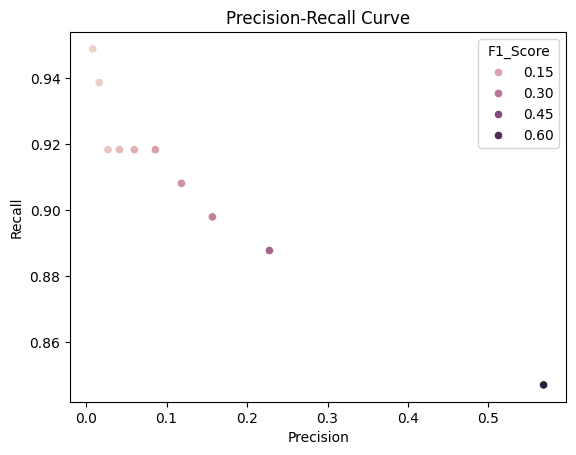

In [ ]:
thresholds = np.linspace(0.1, 0.99, 10)
data = []
for threshold in thresholds:
  no_fraud_probab = pipe.predict_proba(X_test)[:, 1]
  y_pred = (no_fraud_probab > threshold).astype(int)
  f1_score_result = f1_score(y_test, y_pred)
  precision_score_result= precision_score(y_test, y_pred)
  recall_score_result = recall_score(y_test, y_pred)
  print("Logistic Regression scores:")
  print(f"Threshold: {threshold}")
  print(f"- f1 score: {f1_score_result}")
  print(f"- precision score: {precision_score_result}")
  print(f"- recall score: {recall_score_result}")
  data.append((f1_score_result, precision_score_result, recall_score_result))

data_df = pd.DataFrame(data, columns=["F1_Score", "Precision", "Recall"])
sns.scatterplot(data=data_df, x = "Precision", y = "Recall", hue="F1_Score")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

**Note:** Above, I experimented with manipulating the decision threshold to change the model’s final classification and observe how metrics vary. By default, the model classifies a sample as fraud if the predicted probability is >0.5.

This allows us to choose the model that best fits our goals. For example, if we wanted to achieve the most balanced F1 score, we would choose the model with a threshold as high as 0.99 (classifies to fraud only when it’s super confident):

- **F1 score:** 0.6803  
- **Precision:** 0.5685  
- **Recall:** 0.8469  

This shows that manipulating the threshold can significantly improve the F1 score—it’s not only important how the model is trained but also how it makes its choices.


In [ ]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
fraud_count = y_resampled.value_counts()
fraud_count = fraud_count.rename({0: "No Fraud", 1: "Fraud"})
print(fraud_count)

Class
No Fraud    227451
Fraud       227451
Name: count, dtype: int64


**Note:** For the next models, I will use SMOTE instead of `class_weight` parameter. It "smartly" creates additional samples using interpolation — meaning it takes two points and generates a new sample with values in between them. This is helpful in our case because of the very small number of fraud samples in the training set. I used it here just to practice how it works; however, I will apply it separately in every model pipeline to prevent data leakage.

In [ ]:
pipe = imbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE()),
    ("model", LogisticRegression(random_state = 42))
])

In [ ]:
cv_results = cross_validate(
    pipe, X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)
print(f"F1 Score: {cv_results['test_f1']}")
print(f"Precision Score: {cv_results['test_precision']}")
print(f"Recall Score: {cv_results['test_recall']}")

F1 Score: [0.1046595  0.1136     0.11006289 0.10192837 0.11472868]
Precision Score: [0.05542901 0.06063194 0.05867561 0.05389658 0.06110652]
Recall Score: [0.93589744 0.89873418 0.88607595 0.93670886 0.93670886]


**Note:** The process is quite the same as before, however, now we applied SMOTE. The results of cross-validation are very similar to our model without SMOTE. This may be because logistic regression is still a linear model, so adding synthetic points between two already existing points might not be very helpful, as the decision boundary (the "curve") is already linear.


In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
f1_score_result = f1_score(y_test, y_pred)
precision_score_result = precision_score(y_test, y_pred)
recall_score_result = recall_score(y_test, y_pred)
print("Logistic Regression with SMOTE scores on test set:")
print(f"- f1 score: {f1_score_result}")
print(f"- precision score: {precision_score_result}")
print(f"- recall score: {recall_score_result}")

Logistic Regression with SMOTE scores on test set:
- f1 score: 0.10849909584086799
- precision score: 0.057655349135169766
- recall score: 0.9183673469387755


Logistic Regression with SMOTE scores:
Threshold: 0.1
- f1 score: 0.01653186383432584
- precision score: 0.008338563615170807
- recall score: 0.9489795918367347
Logistic Regression with SMOTE scores:
Threshold: 0.14684210526315788
- f1 score: 0.023173803526448364
- precision score: 0.011731701096659015
- recall score: 0.9387755102040817
Logistic Regression with SMOTE scores:
Threshold: 0.1936842105263158
- f1 score: 0.030933150025777626
- precision score: 0.015731515469323543
- recall score: 0.9183673469387755
Logistic Regression with SMOTE scores:
Threshold: 0.24052631578947367
- f1 score: 0.039761431411530816
- precision score: 0.020320614134116052
- recall score: 0.9183673469387755
Logistic Regression with SMOTE scores:
Threshold: 0.2873684210526316
- f1 score: 0.05066141289051506
- precision score: 0.02604920405209841
- recall score: 0.9183673469387755
Logistic Regression with SMOTE scores:
Threshold: 0.3342105263157895
- f1 score: 0.062111801242236024
- precision score: 0.03214285

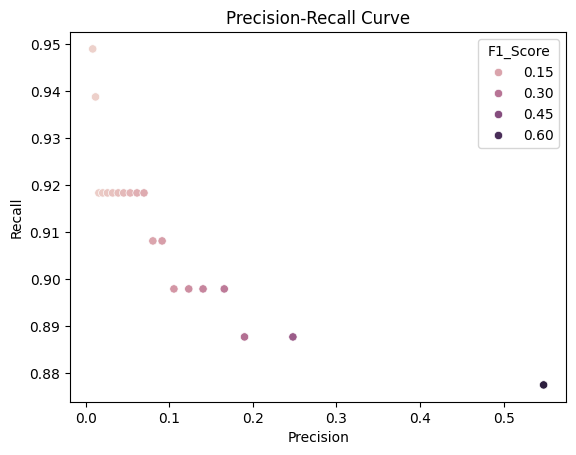

In [ ]:
thresholds = np.linspace(0.1, 0.99, 20)
data = []
for threshold in thresholds:
  no_fraud_probab = pipe.predict_proba(X_test)[:, 1]
  y_pred = (no_fraud_probab > threshold).astype(int)
  f1_score_result = f1_score(y_test, y_pred)
  precision_score_result = precision_score(y_test, y_pred)
  recall_score_result = recall_score(y_test, y_pred)
  print("Logistic Regression with SMOTE scores:")
  print(f"Threshold: {threshold}")
  print(f"- f1 score: {f1_score_result}")
  print(f"- precision score: {precision_score_result}")
  print(f"- recall score: {recall_score_result}")
  data.append((f1_score_result, precision_score_result, recall_score_result))

data_df = pd.DataFrame(data, columns=["F1_Score", "Precision", "Recall"])
sns.scatterplot(data=data_df, x = "Precision", y = "Recall", hue="F1_Score")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

**Note:** The curve looks very similar to linear regression with `class_weight='balanced'` instead of SMOTE. The lower the precision and F1 score, the higher the recall. The higher the precision, the higher the F1 score naturally, and the lower the recall — which is what we would expect. Again, we can choose the model that aligns with our needs. For example, if we still want to check "suspicious transactions" manually, we would go for a high-recall model just to be sure. If the system is fully automatic, we would rather go for high precision.

In [ ]:
grid_parameters = {
    "model__max_depth": [None, 4, 6],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5]
}

**Note:** Now, we move on to tree-based models, starting with the Decision Tree Classifier. Because tree parameters significantly affect performance, I decided to use GridSearchCV to automatically select the best parameters based on the F1 score.


In [ ]:
pipe = imbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])

In [ ]:
grid = GridSearchCV(estimator=pipe, param_grid=grid_parameters, scoring='f1', cv=cv, n_jobs=8)
grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 4, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...]}"
,scoring,'f1'
,n_jobs,8
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [ ]:
gridCV_results = pd.DataFrame(grid.cv_results_)
print("Decision tree best parameters:")
print(grid.best_params_)

Decision tree best parameters:
{'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}


**Note:** Above we can see the parameters that gave our tree the best performance - let’s go with this model! The parameters are: `max_depth=None` (tree can expand with no limits), `min_samples_leaf=2` (minimum samples required in a leaf), and `min_samples_split=5` (minimum samples required to split a node).  

In [ ]:
best_pipeline = grid.best_estimator_
y_pred = best_pipeline.predict(X_test)
best_model = best_pipeline["model"]

In [ ]:
f1_score_result = f1_score(y_test, y_pred)
precision_score_result = precision_score(y_test, y_pred)
recall_score_result = recall_score(y_test, y_pred)
print("Best Decision tree scores on test set:")
print(f"- f1 score: {f1_score_result}")
print(f"- precision score: {precision_score_result}")
print(f"- recall score: {recall_score_result}")

Best Decision tree scores on test set:
- f1 score: 0.5808823529411765
- precision score: 0.4540229885057471
- recall score: 0.8061224489795918


**Note:** Finally, we can see how our best model performed on real data — the F1 score is around 0.58, which is almost six times higher than that of logistic regression. This improvement is because tree-based models can capture non-linear patterns and interactions in the data that linear models like logistic regression cannot.

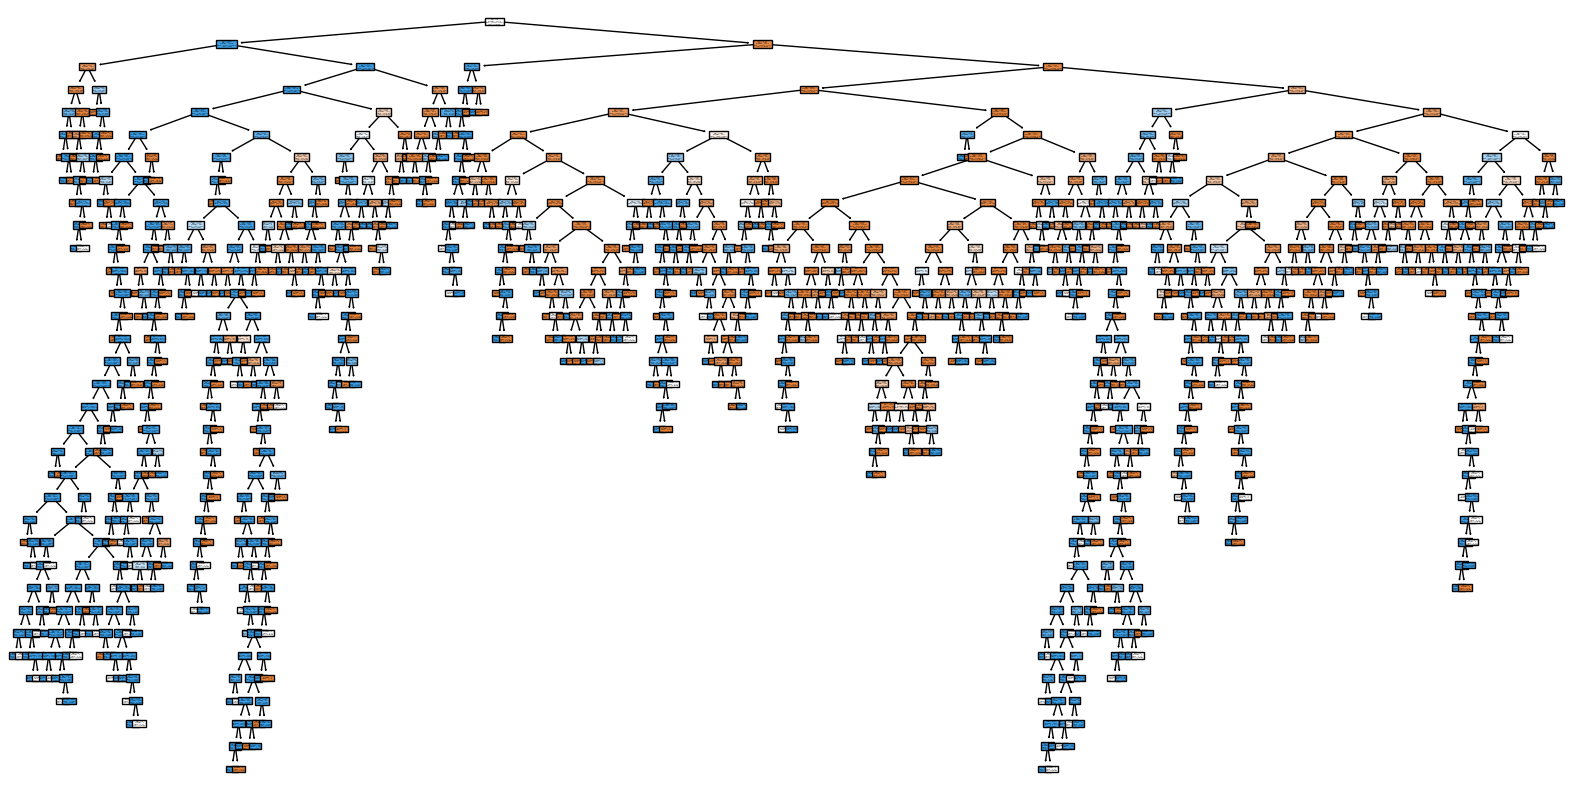

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(best_model, filled=True, feature_names=X_train.columns, class_names=["No Fraud", "Fraud"])
plt.show()

**Note:** The tree above is a visualization of our model, showing nodes and the splits between them. Each node contains information such as the predicted class, the number of samples, and the class distribution, while the edges represent the decision rules that lead from parent to child nodes. However, the tree is extremely large, so it cannot be viewed clearly — mostly because `max_depth=None` allows it to grow without limits.


Decision tree scores:
Threshold: 0.1
- f1 score: 0.53156146179402
- precision score: 0.39408866995073893
- recall score: 0.8163265306122449
Decision tree scores:
Threshold: 0.1988888888888889
- f1 score: 0.53156146179402
- precision score: 0.39408866995073893
- recall score: 0.8163265306122449
Decision tree scores:
Threshold: 0.2977777777777778
- f1 score: 0.53156146179402
- precision score: 0.39408866995073893
- recall score: 0.8163265306122449
Decision tree scores:
Threshold: 0.3966666666666666
- f1 score: 0.5333333333333333
- precision score: 0.39603960396039606
- recall score: 0.8163265306122449
Decision tree scores:
Threshold: 0.4955555555555555
- f1 score: 0.5333333333333333
- precision score: 0.39603960396039606
- recall score: 0.8163265306122449
Decision tree scores:
Threshold: 0.5944444444444444
- f1 score: 0.5808823529411765
- precision score: 0.4540229885057471
- recall score: 0.8061224489795918
Decision tree scores:
Threshold: 0.6933333333333332
- f1 score: 0.58088235294117

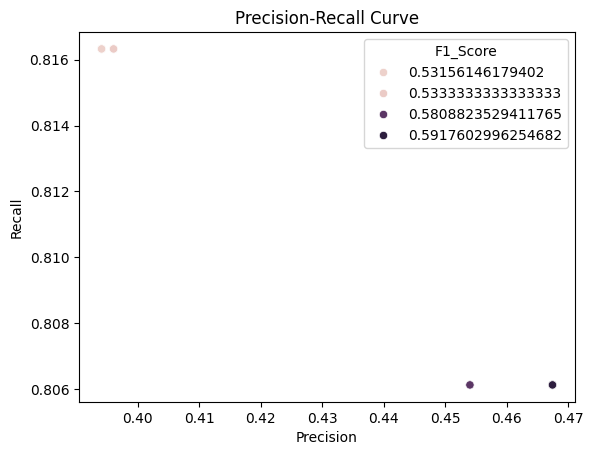

In [ ]:
thresholds = np.linspace(0.1, 0.99, 10)
data = []
for threshold in thresholds:
  no_fraud_probab = best_pipeline.predict_proba(X_test)[:, 1]
  y_pred = (no_fraud_probab > threshold).astype(int)
  f1_score_result = f1_score(y_test, y_pred)
  precision_score_result = precision_score(y_test, y_pred)
  recall_score_result = recall_score(y_test, y_pred)
  print("Decision tree scores:")
  print(f"Threshold: {threshold}")
  print(f"- f1 score: {f1_score_result}")
  print(f"- precision score: {precision_score_result}")
  print(f"- recall score: {recall_score_result}")
  data.append((f1_score_result, precision_score_result, recall_score_result))

data_df = pd.DataFrame(data, columns=["F1_Score", "Precision", "Recall"])
sns.scatterplot(data=data_df, x = "Precision", y = "Recall", hue="F1_Score")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

**Note:** Again, I tested different thresholds, now for the Decision Tree model. The highest F1 score reached around 0.59, which is almost the same as the score from the default threshold. The improvement is minimal because Decision Trees do not output calibrated probabilities — their probability estimates are often coarse and not very reliable — so threshold manipulation has much less impact compared to models like Logistic Regression.

In [ ]:
grid_parameters = {
    "model__n_estimators": [100],
    "model__max_depth": [None, 10],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt"],
}

In [ ]:
pipe = imbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

**Note:** The next model is the Random Forest Classifier, which is basically an ensemble of many decision trees. Because multiple trees vote together, the model is usually more stable and achieves better performance than a single decision tree — so we naturally expect stronger results here.

In [ ]:
grid = GridSearchCV(estimator=pipe, param_grid=grid_parameters, scoring='f1', cv=cv, n_jobs=8)
grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10], 'model__max_features': ['sqrt'], 'model__min_samples_leaf': [1, 2], 'model__min_samples_split': [2, 10], ...}"
,scoring,'f1'
,n_jobs,8
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [ ]:
gridCV_results = pd.DataFrame(grid.cv_results_)
print("Random forest best parameters:")
print(grid.best_params_)

Random forest best parameters:
{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


**Note:** These best parameters mean the Random Forest will build 100 trees (`n_estimators`). At every split, a tree considers only the square root of the features (`max_features='sqrt'`) to reduce correlation between trees. The rest of parameters correspond to single tree, so they were explained before.

In [ ]:
best_pipeline = grid.best_estimator_
y_pred = best_pipeline.predict(X_test)

In [ ]:
f1_score_result = f1_score(y_test, y_pred)
precision_score_result = precision_score(y_test, y_pred)
recall_score_result = recall_score(y_test, y_pred)
print("Best Random Forest scores on test set:")
print(f"- f1 score: {f1_score_result}")
print(f"- precision score: {precision_score_result}")
print(f"- recall score: {recall_score_result}")

Best Random Forest scores on test set:
- f1 score: 0.826530612244898
- precision score: 0.826530612244898
- recall score: 0.826530612244898


**Note:** As expected, the Random Forest scores are the highest so far. F1, precision, and recall are all identical, which suggests we should verify the model’s behavior by checking how threshold manipulation affects the outputs.

Random forest scores:
Threshold: 0.1
- f1 score: 0.46842105263157896
- precision score: 0.31560283687943264
- recall score: 0.9081632653061225
Random forest scores:
Threshold: 0.14684210526315788
- f1 score: 0.5933333333333334
- precision score: 0.4405940594059406
- recall score: 0.9081632653061225
Random forest scores:
Threshold: 0.1936842105263158
- f1 score: 0.6717557251908397
- precision score: 0.5365853658536586
- recall score: 0.8979591836734694
Random forest scores:
Threshold: 0.24052631578947367
- f1 score: 0.7280334728033473
- precision score: 0.6170212765957447
- recall score: 0.8877551020408163
Random forest scores:
Threshold: 0.2873684210526316
- f1 score: 0.7631578947368421
- precision score: 0.6692307692307692
- recall score: 0.8877551020408163
Random forest scores:
Threshold: 0.3342105263157895
- f1 score: 0.7926267281105991
- precision score: 0.7226890756302521
- recall score: 0.8775510204081632
Random forest scores:
Threshold: 0.3810526315789473
- f1 score: 0.813397129

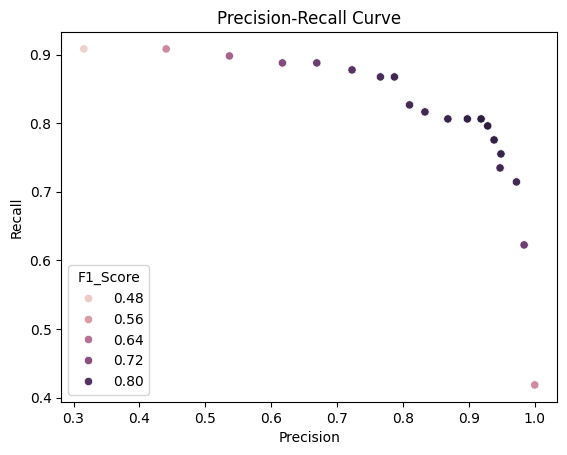

In [ ]:
thresholds = np.linspace(0.1, 0.99, 20)
data = []
for threshold in thresholds:
  no_fraud_probab = best_pipeline.predict_proba(X_test)[:, 1]
  y_pred = (no_fraud_probab > threshold).astype(int)
  f1_score_result = f1_score(y_test, y_pred)
  precision_score_result = precision_score(y_test, y_pred)
  recall_score_result = recall_score(y_test, y_pred)
  print("Random forest scores:")
  print(f"Threshold: {threshold}")
  print(f"- f1 score: {f1_score_result}")
  print(f"- precision score: {precision_score_result}")
  print(f"- recall score: {recall_score_result}")
  data.append((f1_score_result, precision_score_result, recall_score_result))

data_df = pd.DataFrame(data, columns=["F1_Score", "Precision", "Recall"])
sns.scatterplot(data=data_df, x = "Precision", y = "Recall", hue="F1_Score")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

**Note:** The Random Forest behaves as expected: at low thresholds, recall is very high but precision is low, and at high thresholds, precision approaches 1 while recall drops.  The best trade-off between precision and recall is around thresholds 0.6–0.7, where the F1 score reaches 0.85, making this the most balanced model for now.

In [ ]:
grid_parameters = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

**Note:** The last model — XGBClassifier — is basically like a Random Forest but with learning: it builds trees one by one, each trying to fix the errors of the previous ones. The new parameters are `learning_rate` (how much each tree affects the final result), `subsample` (how much of the data each tree sees), and `colsample_bytree` (how many features each tree uses).

In [ ]:
pipe = imbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(random_state=42))
])

In [ ]:
grid = GridSearchCV(estimator=pipe, param_grid=grid_parameters, cv=cv, scoring='f1', n_jobs=8)
grid.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8, 1.0], 'model__learning_rate': [0.05, 0.1, ...], 'model__max_depth': [3, 4, ...], 'model__n_estimators': [100, 200], ...}"
,scoring,'f1'
,n_jobs,8
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [ ]:
gridCV_results = pd.DataFrame(grid.cv_results_)
print("XGB Classifier best parameters:")
print(grid.best_params_)

XGB Classifier best parameters:
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}


In [ ]:
best_pipeline = grid.best_estimator_
y_pred = best_pipeline.predict(X_test)

In [ ]:
f1_score_result = f1_score(y_test, y_pred)
precision_score_result = precision_score(y_test, y_pred)
recall_score_result = recall_score(y_test, y_pred)
print("Best XGB Classifier scores on test set:")
print(f"- f1 score: {f1_score_result}")
print(f"- precision score: {precision_score_result}")
print(f"- recall score: {recall_score_result}")

Best XGB Classifier scores on test set:
- f1 score: 0.8374384236453202
- precision score: 0.8095238095238095
- recall score: 0.8673469387755102


**Note:** The best XGB Classifier performed really well on the test set: F1 score is 0.84, precision is 0.81, and recall is 0.87 - this means the model is both catching most frauds (high recall) and keeping false positives relatively low (good precision), giving a strong balance overall.

XGBClassifier scores:
Threshold: 0.1
- f1 score: 0.7160493827160493
- precision score: 0.6
- recall score: 0.8877551020408163
XGBClassifier scores:
Threshold: 0.1988888888888889
- f1 score: 0.7610619469026548
- precision score: 0.671875
- recall score: 0.8775510204081632
XGBClassifier scores:
Threshold: 0.2977777777777778
- f1 score: 0.783410138248848
- precision score: 0.7142857142857143
- recall score: 0.8673469387755102
XGBClassifier scores:
Threshold: 0.3966666666666666
- f1 score: 0.7981220657276995
- precision score: 0.7391304347826086
- recall score: 0.8673469387755102
XGBClassifier scores:
Threshold: 0.4955555555555555
- f1 score: 0.8292682926829268
- precision score: 0.794392523364486
- recall score: 0.8673469387755102
XGBClassifier scores:
Threshold: 0.5944444444444444
- f1 score: 0.84
- precision score: 0.8235294117647058
- recall score: 0.8571428571428571
XGBClassifier scores:
Threshold: 0.6933333333333332
- f1 score: 0.8442211055276382
- precision score: 0.8316831683168316

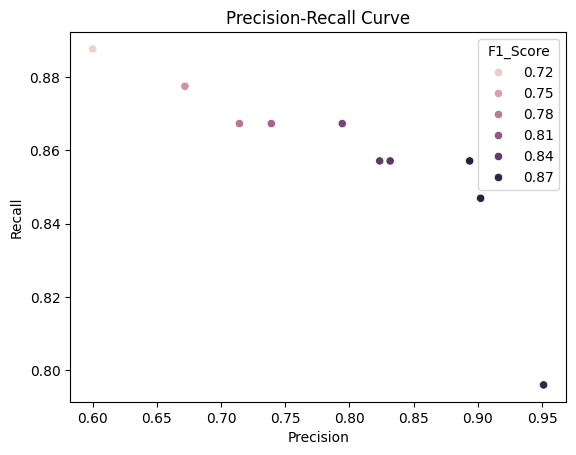

In [ ]:
thresholds = np.linspace(0.1, 0.99, 10)
data = []
for threshold in thresholds:
  no_fraud_probab = best_pipeline.predict_proba(X_test)[:, 1]
  y_pred = (no_fraud_probab > threshold).astype(int)
  f1_score_result = f1_score(y_test, y_pred)
  precision_score_result = precision_score(y_test, y_pred)
  recall_score_result = recall_score(y_test, y_pred)
  print("XGBClassifier scores:")
  print(f"Threshold: {threshold}")
  print(f"- f1 score: {f1_score_result}")
  print(f"- precision score: {precision_score_result}")
  print(f"- recall score: {recall_score_result}")
  data.append((f1_score_result, precision_score_result, recall_score_result))

data_df = pd.DataFrame(data, columns=["F1_Score", "Precision", "Recall"])
sns.scatterplot(data=data_df, x = "Precision", y = "Recall", hue="F1_Score")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

**Note:** The best threshold seems to be aroud 0.79, where F1 reaches 0.88, precision 0.89, and recall 0.86 — it is the highest F1 score so far!


                                Model  F1_Score  Precision  Recall
Logistic Regression\n(threshold=0.99)      0.68       0.57    0.85
 Decision Tree\n(threshold=0.79-0.99)      0.59       0.47    0.81
      Random Forest\n(threshold=0.66)      0.86       0.92    0.81
            XGBoost\n(threshold=0.79)      0.88       0.89    0.86


<Figure size 800x500 with 0 Axes>

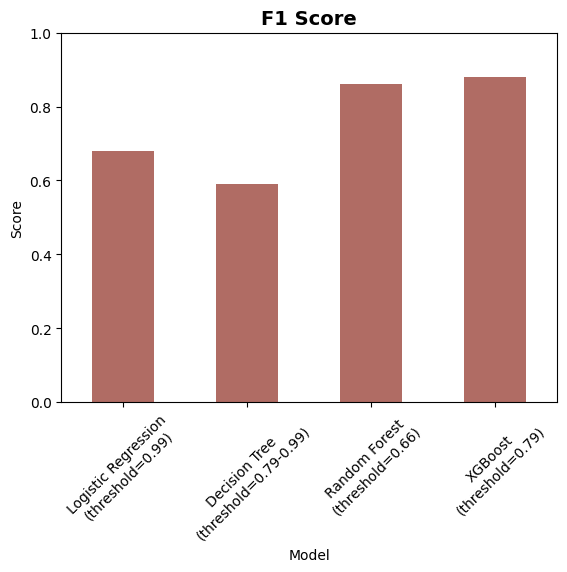

<Figure size 800x500 with 0 Axes>

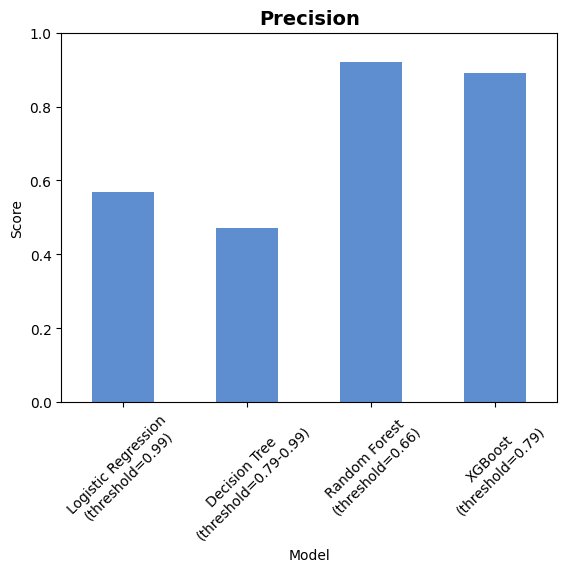

<Figure size 800x500 with 0 Axes>

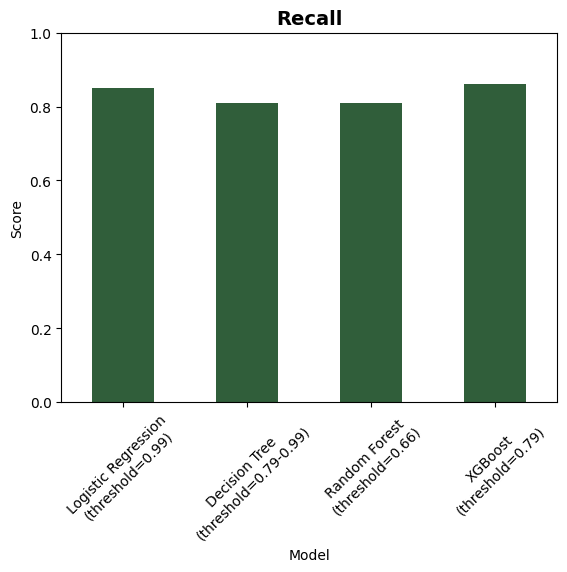

In [ ]:
results_summary = {
    'Model': [
        'Logistic Regression\n(threshold=0.99)',
        'Decision Tree\n(threshold=0.79-0.99)',
        'Random Forest\n(threshold=0.66)',
        'XGBoost\n(threshold=0.79)'
    ],

    'F1_Score': [0.68, 0.59, 0.86, 0.88],
    'Precision': [0.57, 0.47, 0.92, 0.89],
    'Recall': [0.85, 0.81, 0.81, 0.86]
}

results_df = pd.DataFrame(results_summary)
print(results_df.to_string(index=False))

plt.figure(figsize=(8, 5))
results_df.plot(x='Model', y='F1_Score', kind='bar', legend=False, color="#b06c64")
plt.title('F1 Score', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45, fontsize=10)
plt.show()

plt.figure(figsize=(8, 5))
results_df.plot(x='Model', y='Precision', kind='bar', legend=False, color="#5e8dd0")
plt.title('Precision', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45, fontsize=10)
plt.show()

plt.figure(figsize=(8, 5))
results_df.plot(x='Model', y='Recall', kind='bar', legend=False, color="#305e3a")
plt.title('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45, fontsize=10)
plt.show()

**Note:** Finally, I've looked through each model type and chosen the best model in each type based on F1 score.

As we can see in the plots, the highest F1 scores — and general balance — were achieved by Random Forest and XGB Classifier. What's interesting is that Logistic Regression reached a higher F1 than the Decision Tree.

In precision, the Random Forest and XGB Classifier also dominate, while recall is quite similar for all 4 models.

**Note:** Thus, out of these four, **the best model is XGBoost** (threshold = 0.79 and SMOTE applied) as it achieves the highest **F1 score of 0.88** while maintaining a strong balance between precision (0.89) and recall (0.86). Random Forest is also very good with high F1 and precision, but slightly lower recall. However, the choice of our model should be based on our actual needs — whether we want to catch almost all frauds at the risk of some false positives, or we prefer a more reliable model with fewer false alarms.
